# Learning to Control a Dynamical System

## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

We need to install a more recent version of matplotlib than is offered in the default Colab environment. After running the cell 1 for the first time in a new Colab runtime, you will see the prompt: "You must restart the runtime in order to use newly installed versions." After restarting, the correct version of matplotlib will be loaded for the duration of the current runtime.

In [ ]:
!pip install --upgrade matplotlib

In [ ]:
!pip install setuptools==61.0.0 casadi mlflow torchdiffeq dill pyts plum-dispatch==1.7.3 --user
!pip install git+https://github.com/pnnl/neuromancer.git@master --ignore-requires-python --no-deps --user

## Typical scenario. Off policy control learning

In a typical real world control setting, due to cost and operational concerns, there is not an opportunity to directly interact with the system to learn a controller. In this scenario, the system is perturbed for some amount of time to collect measurements representative of the system state space, system identification is performed, and a controller is created based on the fitted model created via system identification. In the following cells we walk through the three stage process of generating data, system identification, and control policy learning using neuromancer. 

## Instantiate a system emulator from neuromancer.psl

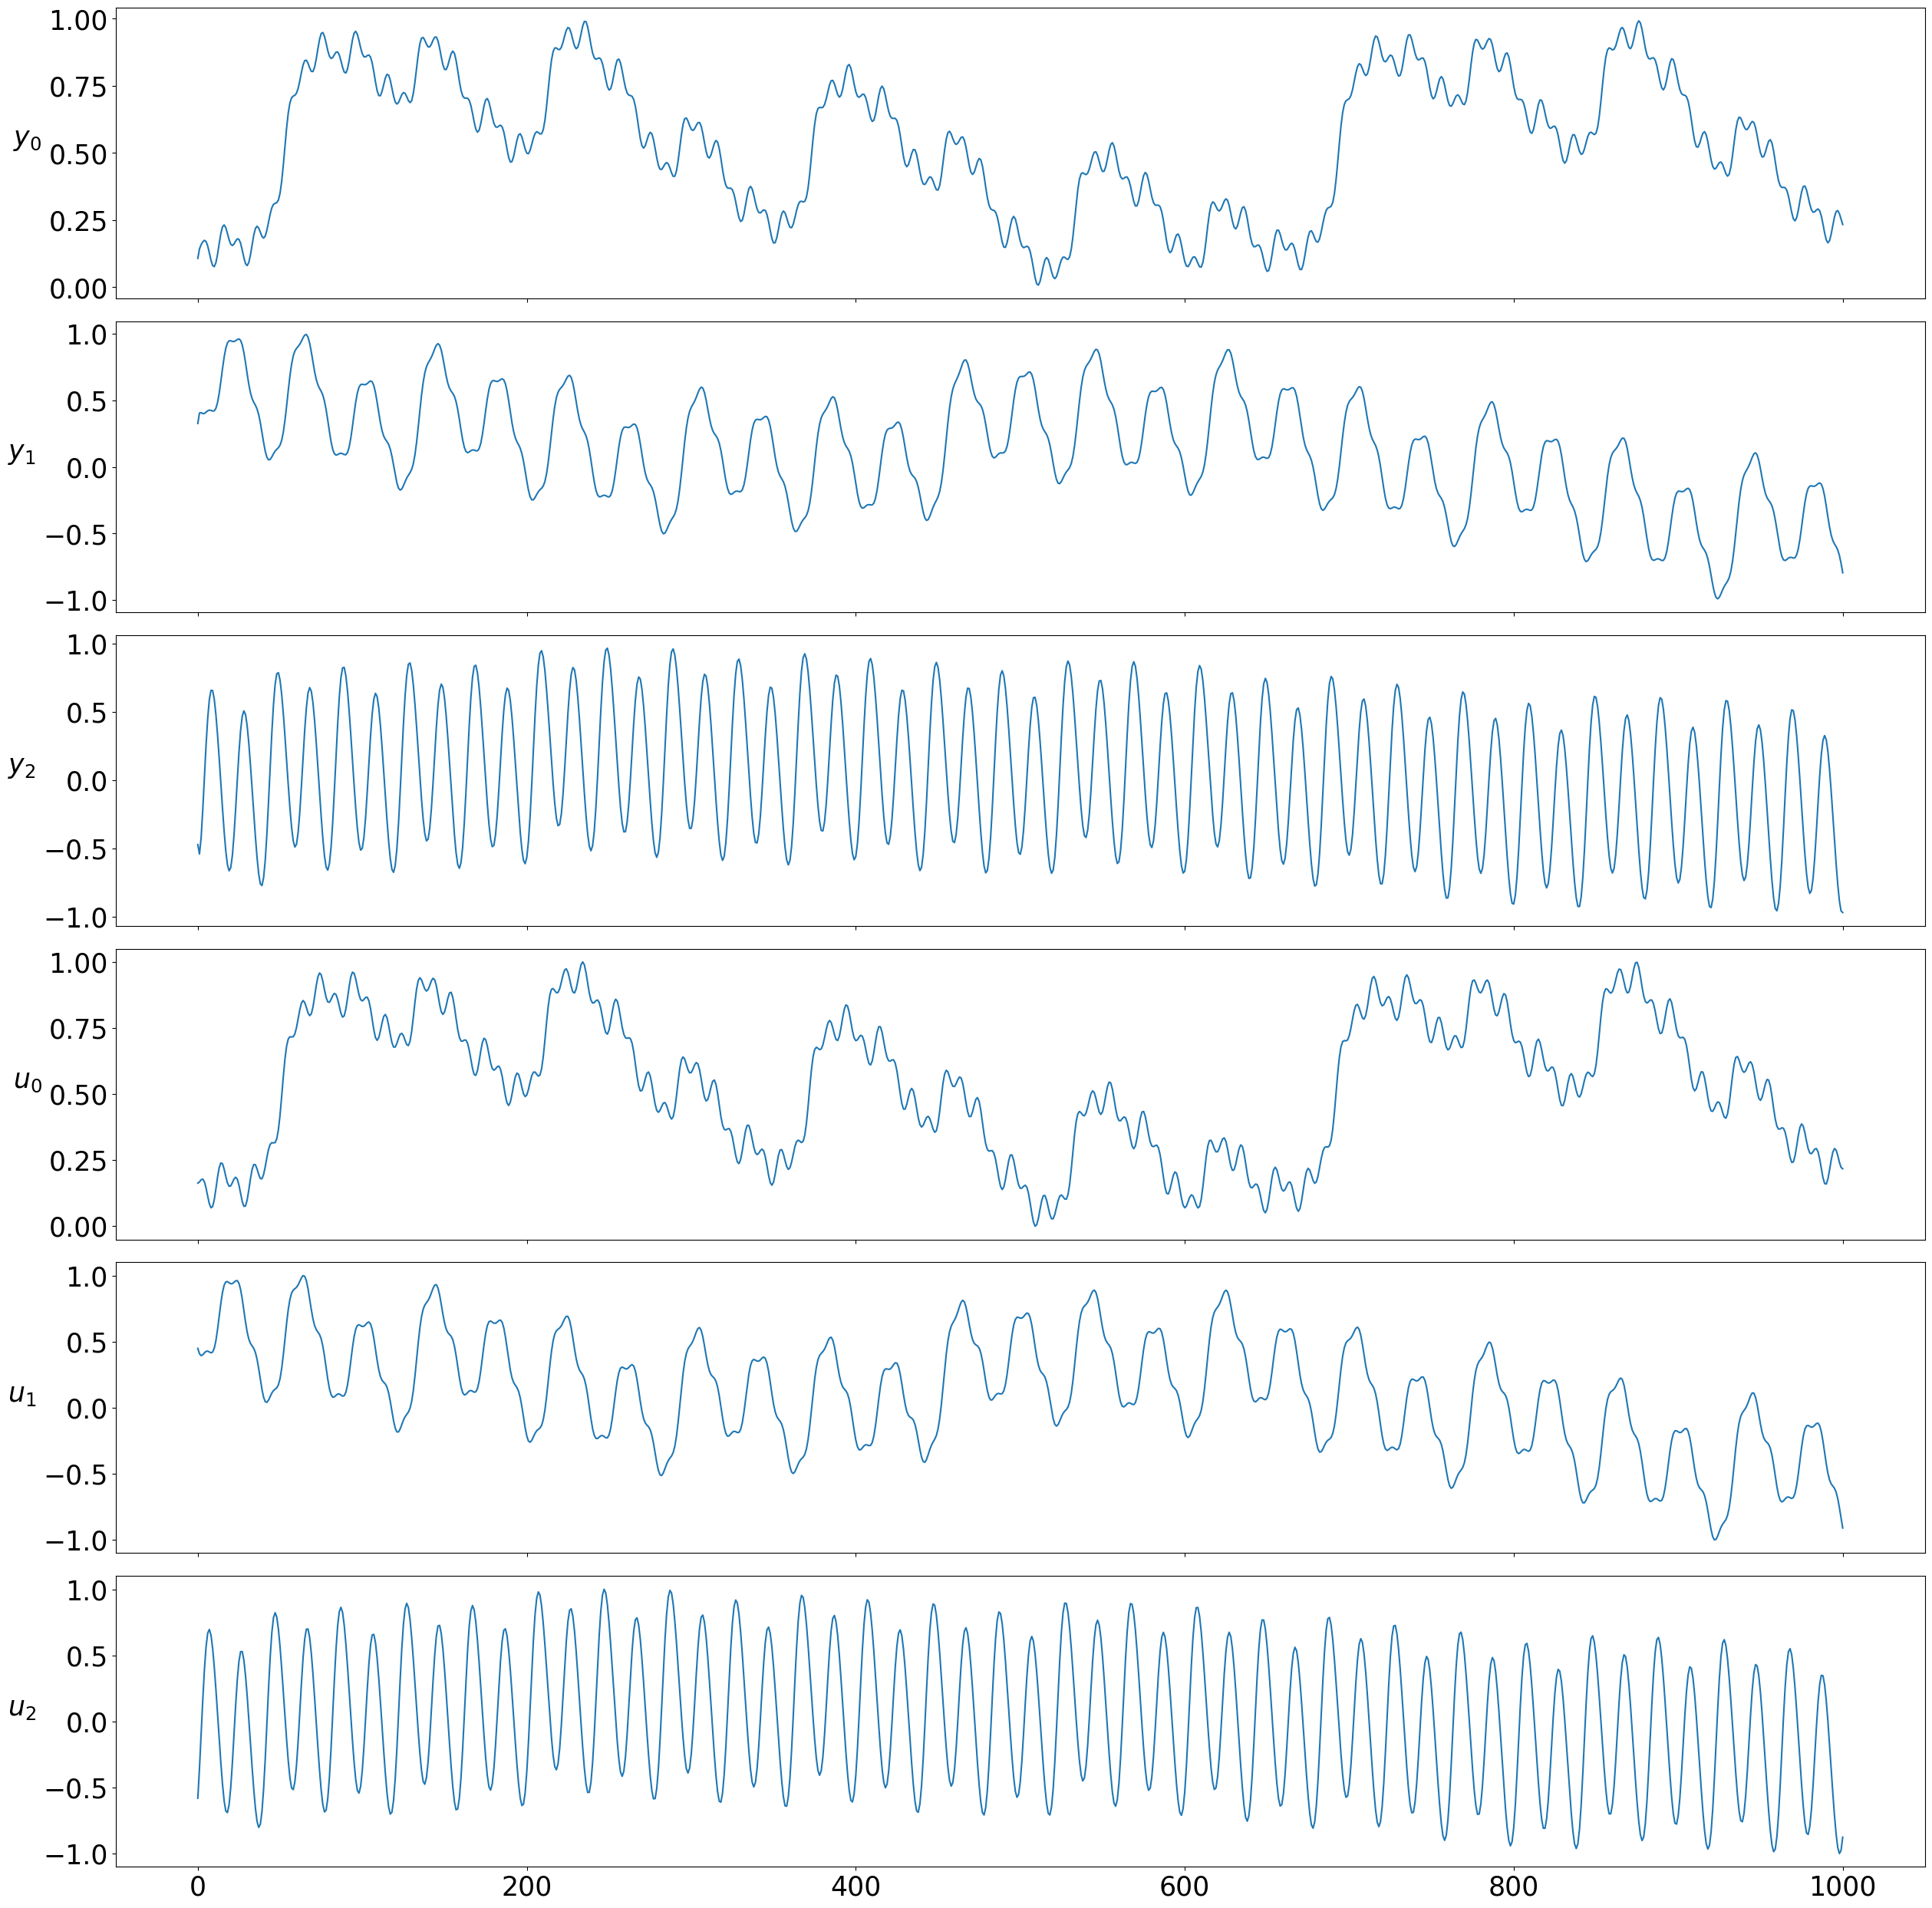

In [1]:
from neuromancer.psl.nonautonomous import Actuator
from neuromancer.dataset import DictDataset
sys = Actuator()
sys.show()

# Define a simple neural ODE model of the system

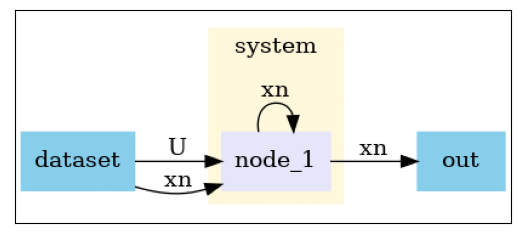

In [2]:
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.dynamics import integrators
import torch

dx = blocks.MLP(sys.nx + sys.nu, sys.nx, bias=True, linear_map=torch.nn.Linear, nonlin=torch.nn.ELU,
              hsizes=[20 for h in range(3)])
interp_u = lambda tq, t, u: u
integrator = integrators.Euler(dx, h=torch.tensor(0.1), interp_u=interp_u)
system_node = Node(integrator, ['xn', 'U'], ['xn'])
model = System([system_node])
model.show()

# Generate datasets representative of system behavior

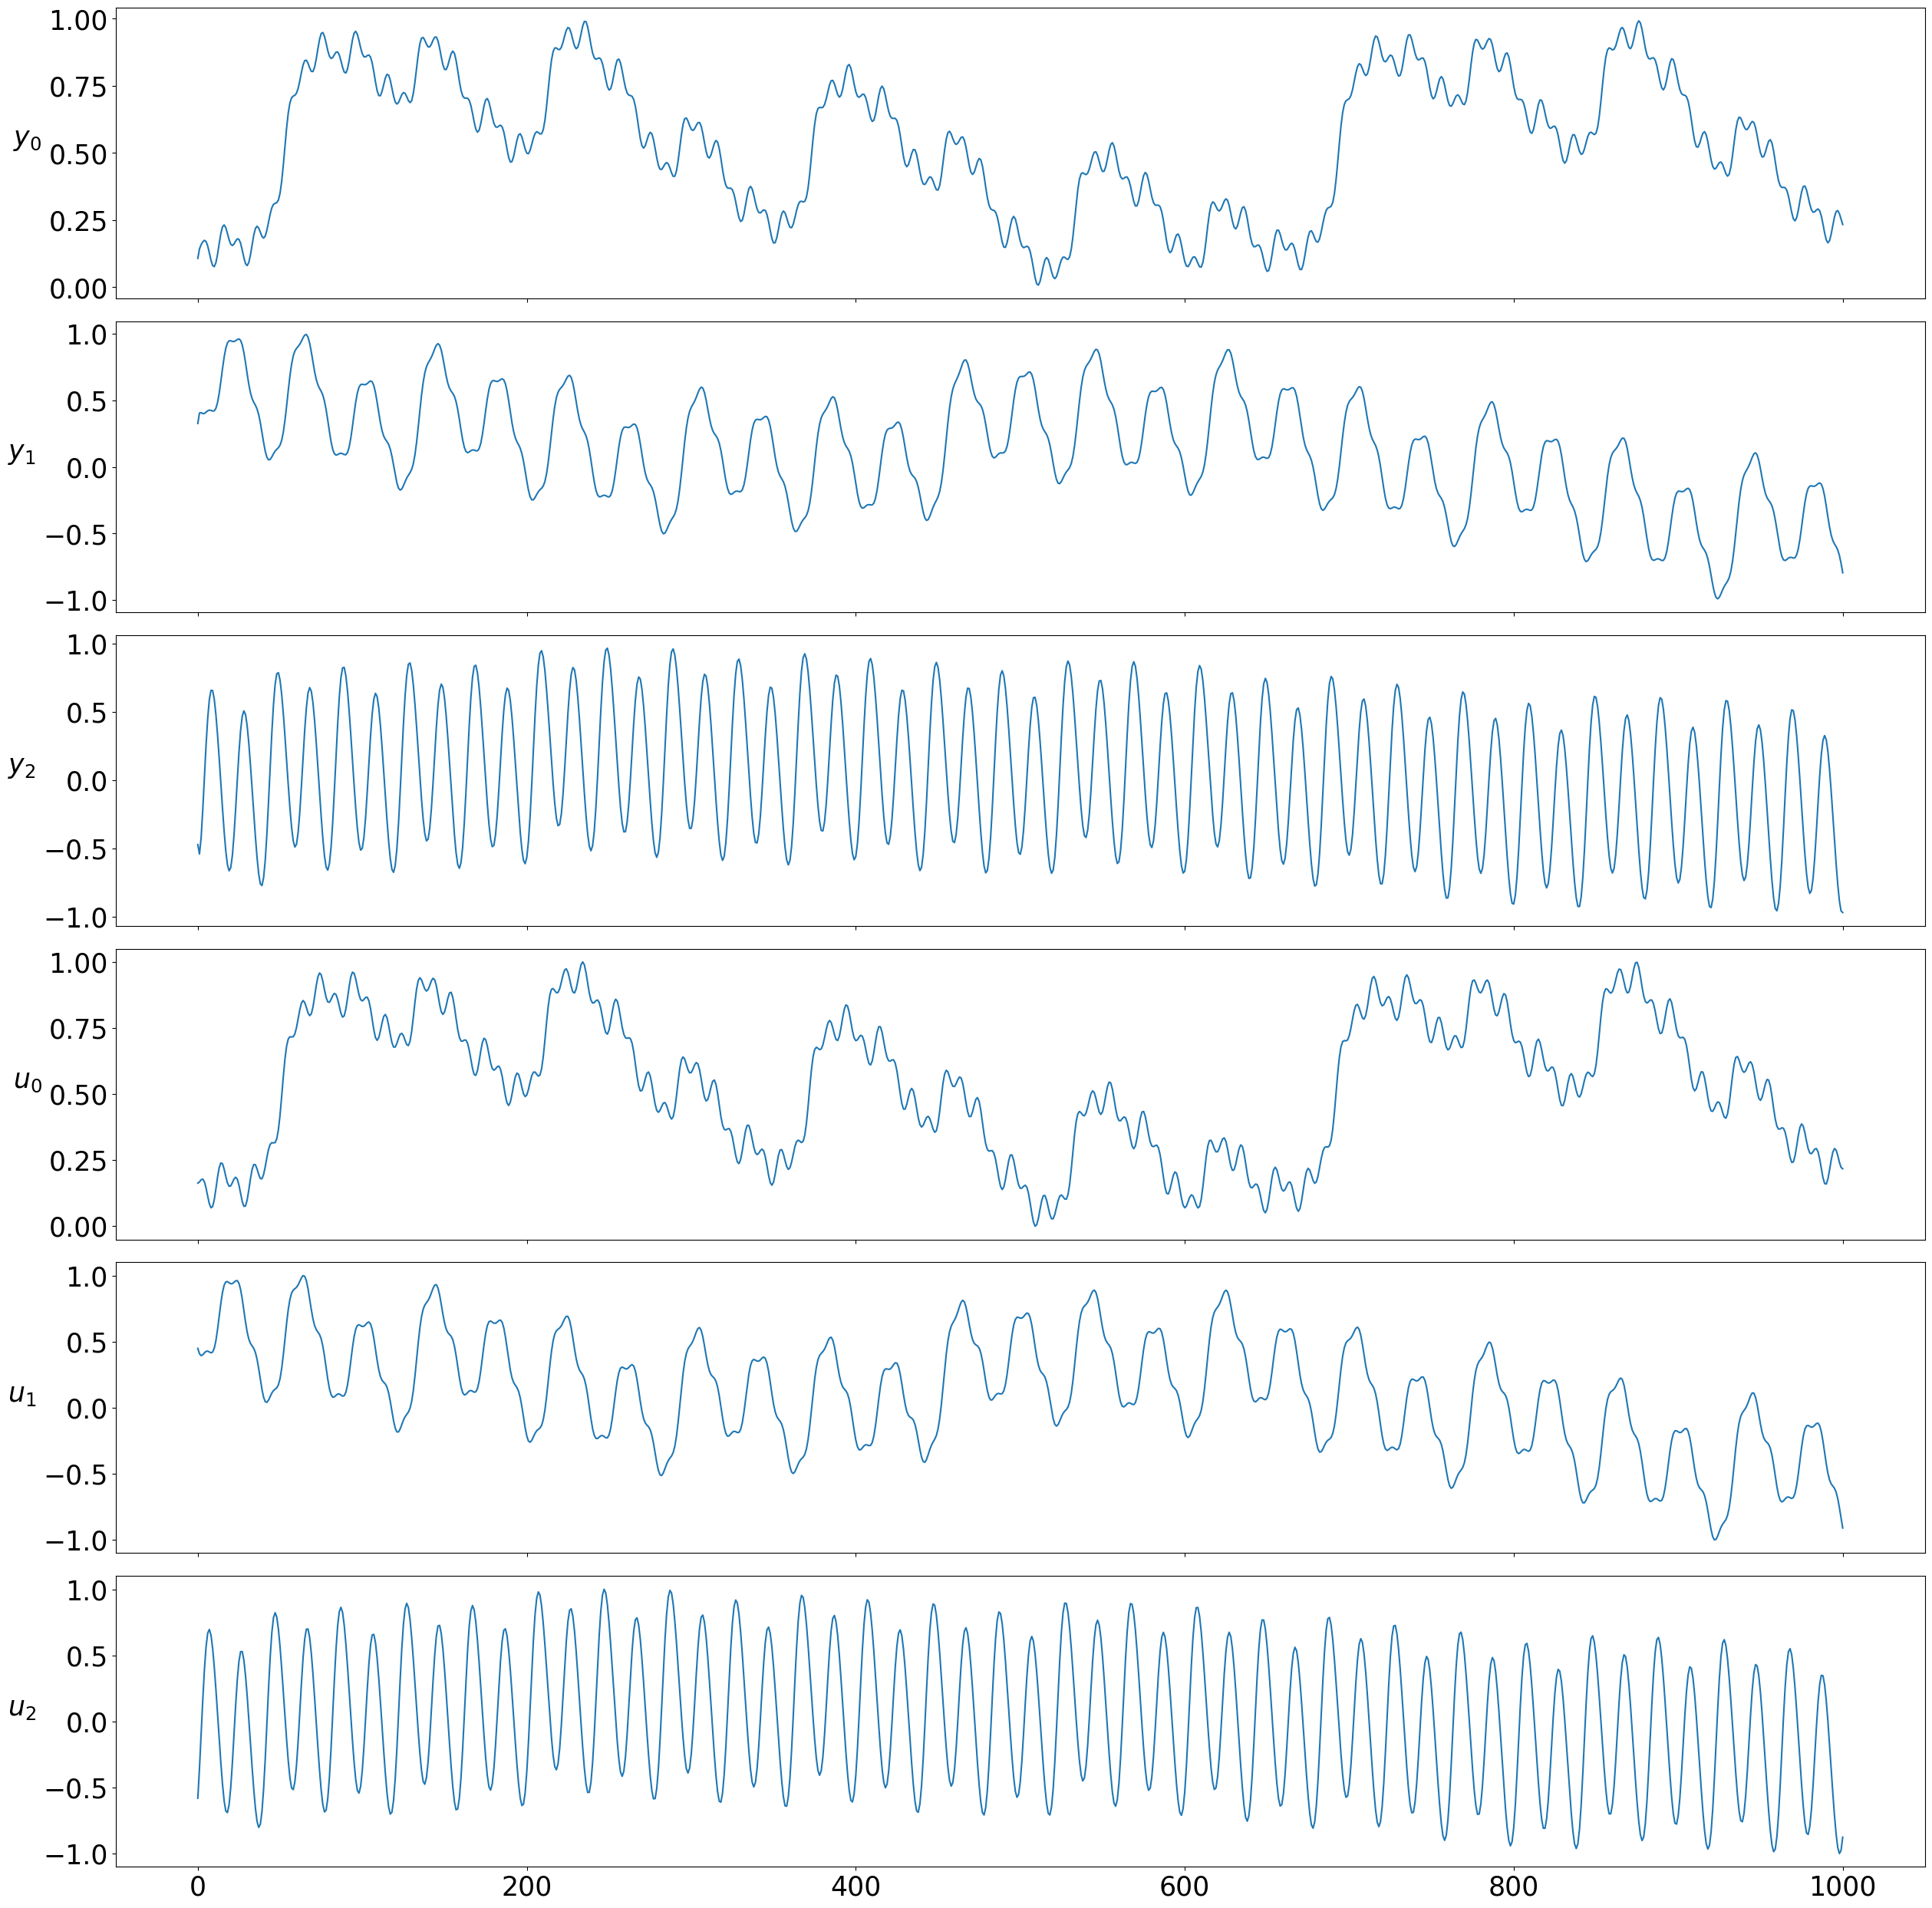

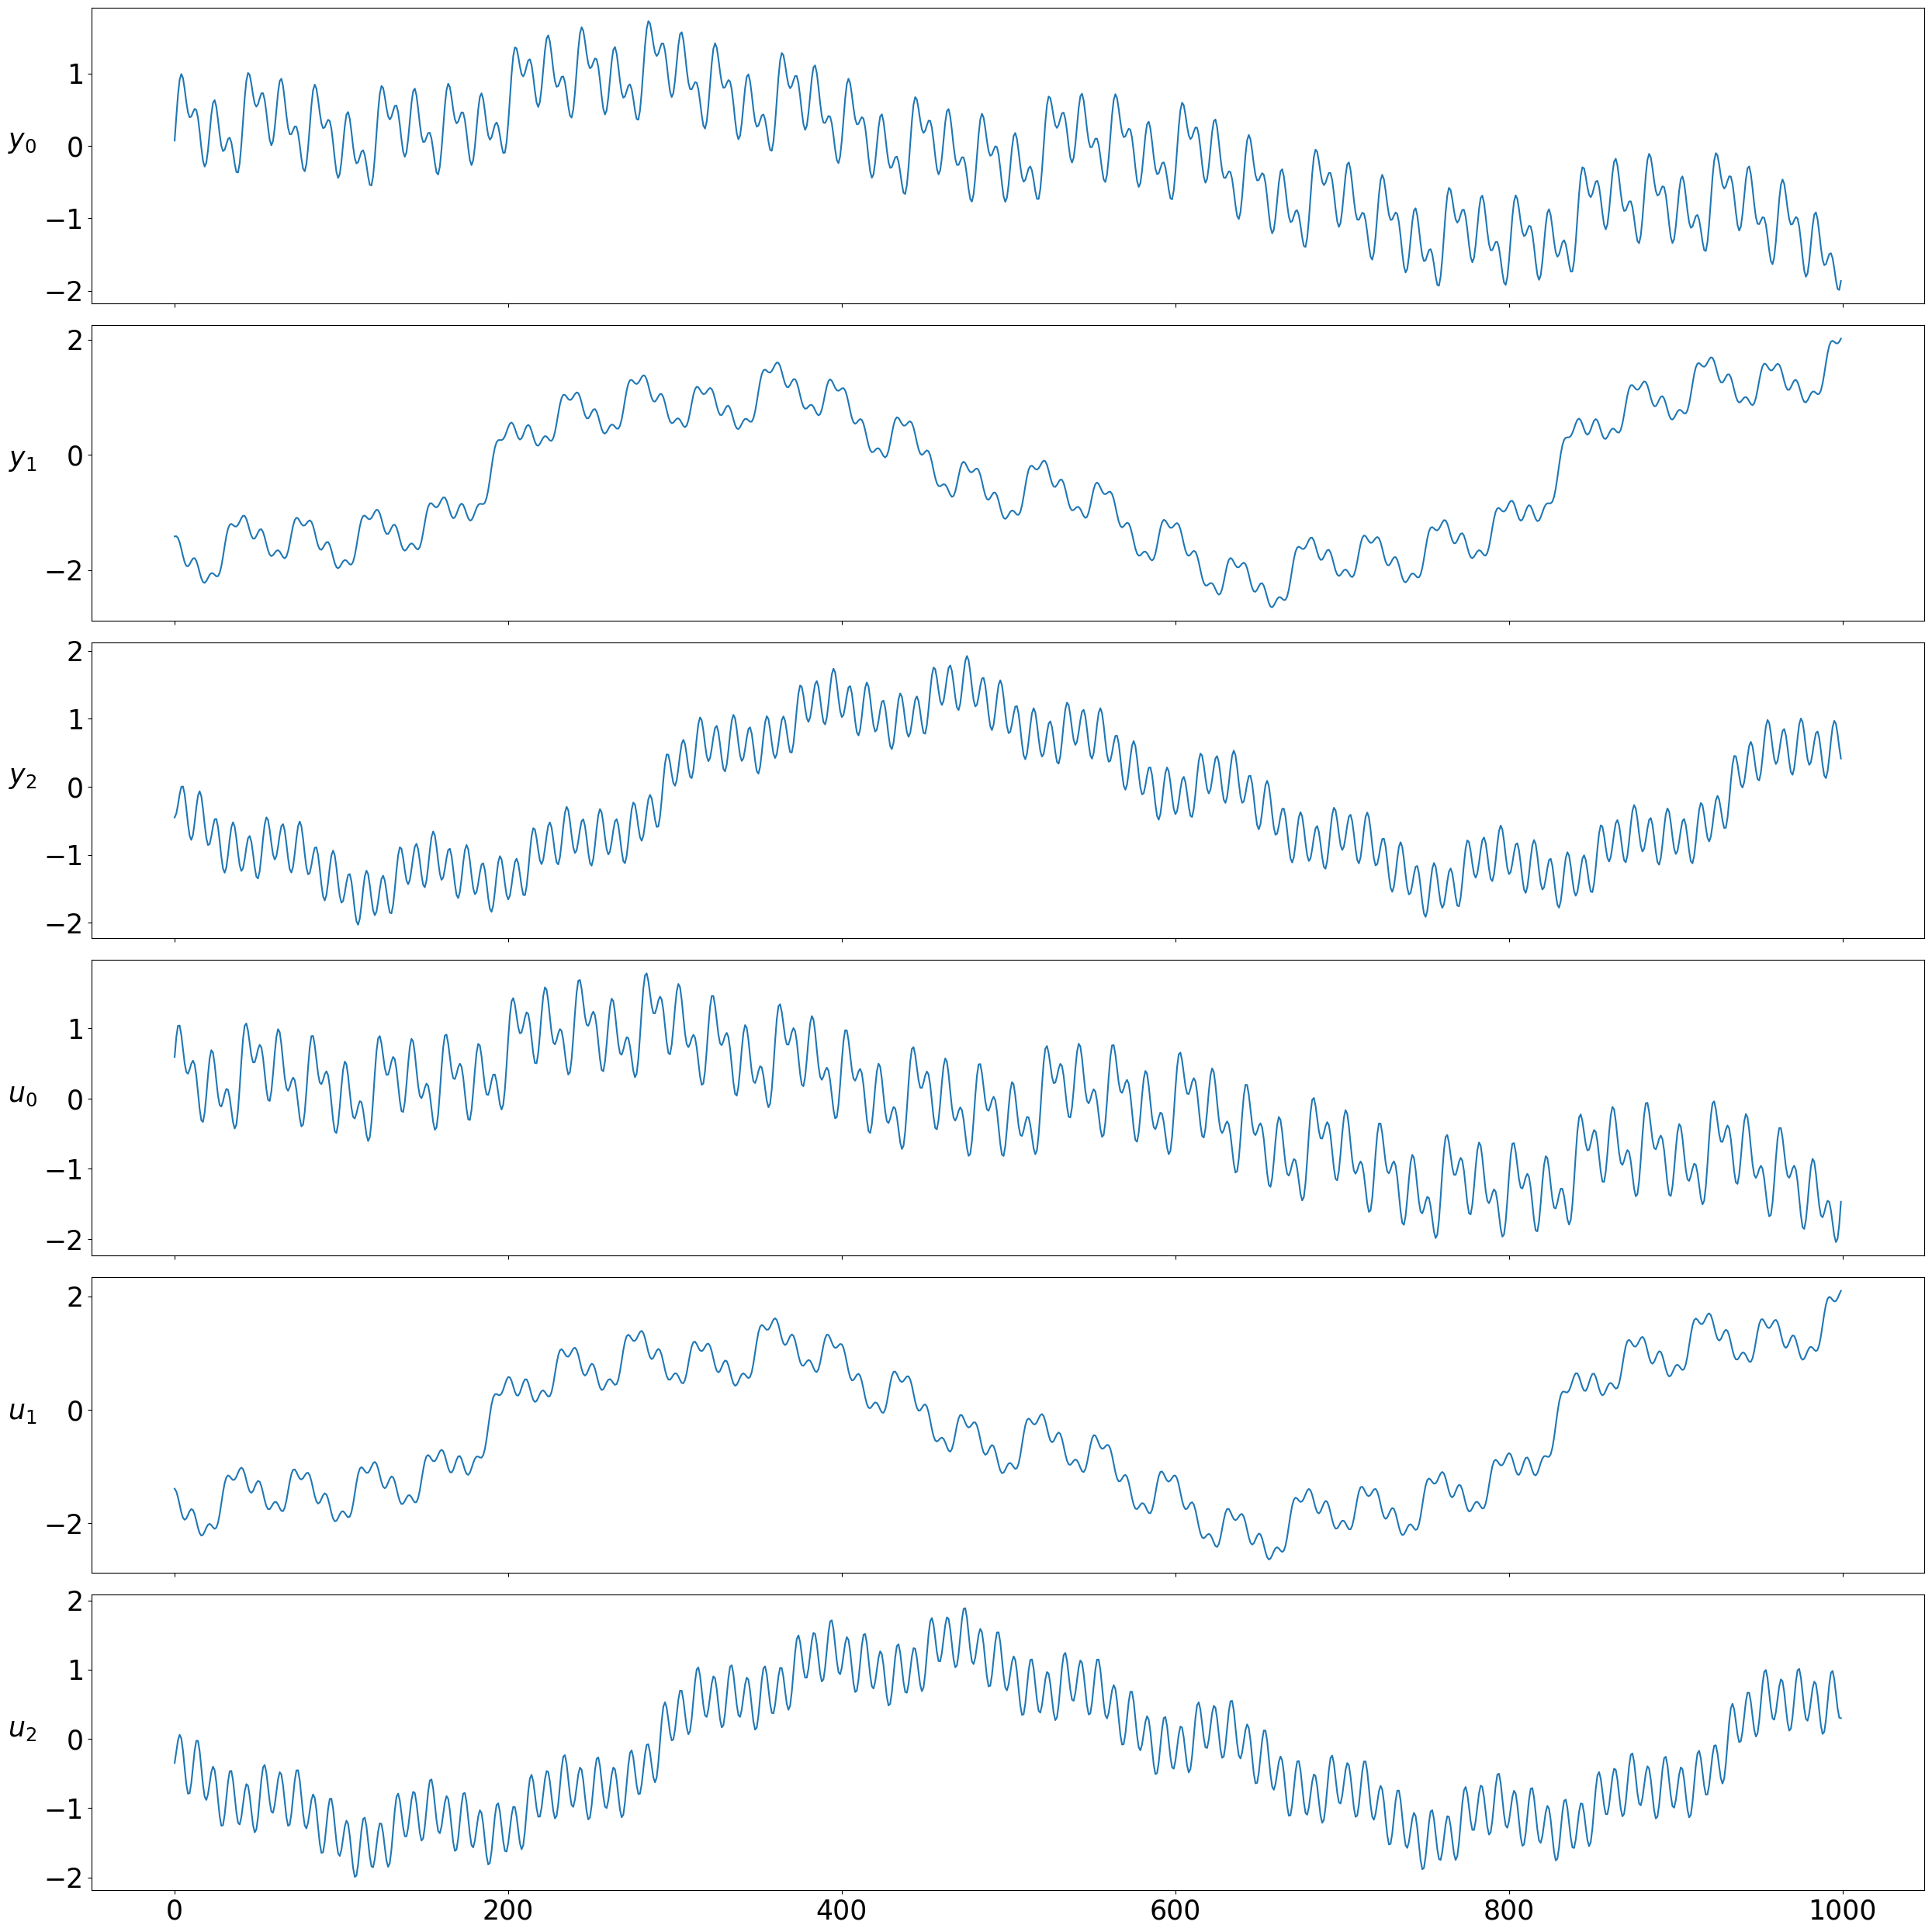

In [5]:
train_data, dev_data, test_data = [sys.simulate(nsim=1000) for i in range(3)]
sys.show()

from torch.utils.data import DataLoader
train_data, dev_data, test_data = [sys.normalize(d) for d in [train_data, dev_data, test_data]]
sys.show(train_data)
# Set up the data to be in samples of 10 contiguous time steps (100 samples with 10 time steps each last dim is dimension of the measured variable)
for d in [train_data, dev_data]:
    d['X'] = d['X'].reshape(100, 10, 3)
    d['U'] = d['U'].reshape(100, 10, 3)
    d['Y'] = d['Y'].reshape(100, 10, 3)
    d['xn'] = d['X'][:, 0:1, :] # Add an initial condition to start the system loop
    d['Time'] = d['Time'].reshape(100, -1)

train_dataset, dev_dataset, = [DictDataset(d, name=n) for d, n in zip([train_data, dev_data], ['train', 'dev'])]
train_loader, dev_loader = [DataLoader(d, batch_size=100, collate_fn=d.collate_fn, shuffle=True) for d in [train_dataset, dev_dataset]]


# Define the optimization problem

In [4]:
from neuromancer.constraint import variable
from neuromancer.problem import Problem
from neuromancer.loss import PenaltyLoss

# Nstep rollout predictions from the model
xpred = variable('xn')[:, :-1, :]
# Ground truth data
xtrue = variable('X')

loss = (xpred == xtrue) ^ 2
loss.update_name('loss')

obj = PenaltyLoss([loss], [])
problem = Problem([model], obj)

## Minimize the system identification problem

In [6]:
from neuromancer.trainer import Trainer
import torch.optim as optim

opt = optim.Adam(model.parameters(), 0.001)
trainer = Trainer(problem, train_loader, dev_loader, optimizer=opt,
                  epochs=1000,
                  patience=300,
                  train_metric='train_loss',
                  

                  eval_metric='dev_loss')
best_model = trainer.train()

epoch: 0  train_loss: 0.1370019018650055
epoch: 1  train_loss: 0.13511113822460175
epoch: 2  train_loss: 0.13331517577171326
epoch: 3  train_loss: 0.13161328434944153
epoch: 4  train_loss: 0.13000421226024628
epoch: 5  train_loss: 0.12848572432994843
epoch: 6  train_loss: 0.1270546317100525
epoch: 7  train_loss: 0.1257074624300003
epoch: 8  train_loss: 0.12444069236516953
epoch: 9  train_loss: 0.12325078994035721
epoch: 10  train_loss: 0.12213411182165146
epoch: 11  train_loss: 0.12108693271875381
epoch: 12  train_loss: 0.12010568380355835
epoch: 13  train_loss: 0.11918678879737854
epoch: 14  train_loss: 0.1183268129825592
epoch: 15  train_loss: 0.11752226948738098
epoch: 16  train_loss: 0.1167696937918663
epoch: 17  train_loss: 0.11606564372777939
epoch: 18  train_loss: 0.11540666967630386
epoch: 19  train_loss: 0.11478938907384872
epoch: 20  train_loss: 0.11421047151088715
epoch: 21  train_loss: 0.11366666853427887
epoch: 22  train_loss: 0.11315484344959259
epoch: 23  train_loss: 0.1

epoch: 194  train_loss: 0.010838320478796959
epoch: 195  train_loss: 0.010467268526554108
epoch: 196  train_loss: 0.010103985667228699
epoch: 197  train_loss: 0.009748687967658043
epoch: 198  train_loss: 0.00940158125013113
epoch: 199  train_loss: 0.009062865749001503
epoch: 200  train_loss: 0.008732727728784084
epoch: 201  train_loss: 0.008411340415477753
epoch: 202  train_loss: 0.008098853752017021
epoch: 203  train_loss: 0.007795401383191347
epoch: 204  train_loss: 0.007501094602048397
epoch: 205  train_loss: 0.00721602002158761
epoch: 206  train_loss: 0.006940234452486038
epoch: 207  train_loss: 0.006673768162727356
epoch: 208  train_loss: 0.006416616961359978
epoch: 209  train_loss: 0.006168751511722803
epoch: 210  train_loss: 0.005930108949542046
epoch: 211  train_loss: 0.005700596608221531
epoch: 212  train_loss: 0.0054800910875201225
epoch: 213  train_loss: 0.005268441513180733
epoch: 214  train_loss: 0.005065471865236759
epoch: 215  train_loss: 0.00487098004668951
epoch: 216  

epoch: 387  train_loss: 9.996270091505721e-05
epoch: 388  train_loss: 9.92177301668562e-05
epoch: 389  train_loss: 9.84881553449668e-05
epoch: 390  train_loss: 9.777353261597455e-05
epoch: 391  train_loss: 9.707341814646497e-05
epoch: 392  train_loss: 9.638759365770966e-05
epoch: 393  train_loss: 9.571552072884515e-05
epoch: 394  train_loss: 9.505689376965165e-05
epoch: 395  train_loss: 9.441139263799414e-05
epoch: 396  train_loss: 9.377872629556805e-05
epoch: 397  train_loss: 9.315842180512846e-05
epoch: 398  train_loss: 9.255027543986216e-05
epoch: 399  train_loss: 9.195395250571892e-05
epoch: 400  train_loss: 9.13690819288604e-05
epoch: 401  train_loss: 9.079548908630386e-05
epoch: 402  train_loss: 9.023283928399906e-05
epoch: 403  train_loss: 8.968084875959903e-05
epoch: 404  train_loss: 8.913925557862967e-05
epoch: 405  train_loss: 8.860780508257449e-05
epoch: 406  train_loss: 8.808628626866266e-05
epoch: 407  train_loss: 8.757437899475917e-05
epoch: 408  train_loss: 8.70718722580

epoch: 578  train_loss: 5.408419747254811e-05
epoch: 579  train_loss: 5.399754081736319e-05
epoch: 580  train_loss: 5.3911233408143744e-05
epoch: 581  train_loss: 5.382528979680501e-05
epoch: 582  train_loss: 5.373978638090193e-05
epoch: 583  train_loss: 5.365459946915507e-05
epoch: 584  train_loss: 5.3569798183161765e-05
epoch: 585  train_loss: 5.348536797100678e-05
epoch: 586  train_loss: 5.340130519471131e-05
epoch: 587  train_loss: 5.3317566198529676e-05
epoch: 588  train_loss: 5.323422374203801e-05
epoch: 589  train_loss: 5.315123053151183e-05
epoch: 590  train_loss: 5.306852835929021e-05
epoch: 591  train_loss: 5.2986240916652605e-05
epoch: 592  train_loss: 5.2904208132531494e-05
epoch: 593  train_loss: 5.2822586440015584e-05
epoch: 594  train_loss: 5.274123031995259e-05
epoch: 595  train_loss: 5.266022344585508e-05
epoch: 596  train_loss: 5.257955126580782e-05
epoch: 597  train_loss: 5.249918103800155e-05
epoch: 598  train_loss: 5.2419105486478657e-05
epoch: 599  train_loss: 5.2

epoch: 768  train_loss: 4.170704050920904e-05
epoch: 769  train_loss: 4.1655479435576126e-05
epoch: 770  train_loss: 4.160398384556174e-05
epoch: 771  train_loss: 4.1552608308847994e-05
epoch: 772  train_loss: 4.150134191149846e-05
epoch: 773  train_loss: 4.1450181015534326e-05
epoch: 774  train_loss: 4.139908924116753e-05
epoch: 775  train_loss: 4.1348084778292105e-05
epoch: 776  train_loss: 4.129720400669612e-05
epoch: 777  train_loss: 4.124638871871866e-05
epoch: 778  train_loss: 4.1195638914359733e-05
epoch: 779  train_loss: 4.114504554308951e-05
epoch: 780  train_loss: 4.1094503103522584e-05
epoch: 781  train_loss: 4.1044077079277486e-05
epoch: 782  train_loss: 4.0993731090566143e-05
epoch: 783  train_loss: 4.094347241334617e-05
epoch: 784  train_loss: 4.08933155995328e-05
epoch: 785  train_loss: 4.0843220631359145e-05
epoch: 786  train_loss: 4.07932311645709e-05
epoch: 787  train_loss: 4.0743361751083285e-05
epoch: 788  train_loss: 4.069351780344732e-05
epoch: 789  train_loss: 4.

epoch: 961  train_loss: 3.319701136206277e-05
epoch: 962  train_loss: 3.3159172744490206e-05
epoch: 963  train_loss: 3.3121385058620945e-05
epoch: 964  train_loss: 3.308366649434902e-05
epoch: 965  train_loss: 3.304601341369562e-05
epoch: 966  train_loss: 3.3008378522936255e-05
epoch: 967  train_loss: 3.297084185760468e-05
epoch: 968  train_loss: 3.293333065812476e-05
epoch: 969  train_loss: 3.289586675236933e-05
epoch: 970  train_loss: 3.285845014033839e-05
epoch: 971  train_loss: 3.28211099258624e-05
epoch: 972  train_loss: 3.2783827919047326e-05
epoch: 973  train_loss: 3.2746564102126285e-05
epoch: 974  train_loss: 3.270936576882377e-05
epoch: 975  train_loss: 3.2672262022970244e-05
epoch: 976  train_loss: 3.263516919105314e-05
epoch: 977  train_loss: 3.259815275669098e-05
epoch: 978  train_loss: 3.25611763400957e-05
epoch: 979  train_loss: 3.2524243579246104e-05
epoch: 980  train_loss: 3.2487358112121e-05
epoch: 981  train_loss: 3.245055995648727e-05
epoch: 982  train_loss: 3.24137

## Evaluate system model on 1000 time step rollout

{'Y': (1000, 3), 'X': (1000, 3), 'U': (1000, 3), 'Time': (1000,)}


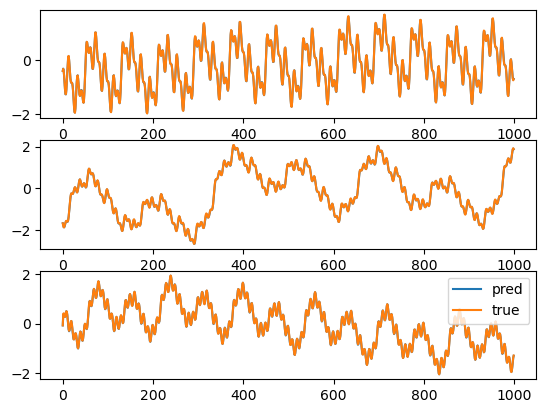

In [7]:
import torch
test_data = sys.normalize(sys.simulate(nsim=1000))
print({k: v.shape for k, v in test_data.items()})

test_data['X'] = test_data['X'].reshape(1, *test_data['X'].shape)
test_data['U'] = test_data['U'].reshape(1, *test_data['U'].shape)
test_data['xn'] = test_data['X'][:, 0:1, :]
test_data = {k: torch.tensor(v, dtype=torch.float32) for k, v in test_data.items()}
test_output = model(test_data)

import matplotlib.pyplot as plt
fix, ax = plt.subplots(nrows=3)
for v in range(3):
    ax[v].plot(test_output['xn'][0, :-1, v].detach().numpy(), label='pred')
    ax[v].plot(test_data['X'][0, :, v].detach().numpy(), label='true')
plt.legend()

## Create a closed loop system using the system model and a parametrized control policy


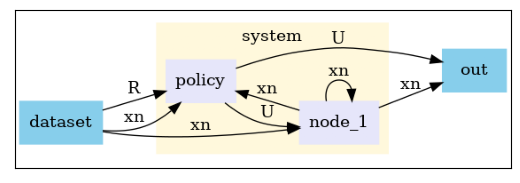

In [8]:
nx, nu = sys.nx, sys.nu

class Policy(torch.nn.Module):

    def __init__(self, insize, outsize):
        super().__init__()
        self.net = blocks.MLP(insize, outsize, bias=True, hsizes=[20, 20, 20])

    def forward(self, x, R):
        features = torch.cat([x, R], dim=-1)
        return self.net(features)

insize = 2*nx
policy = Policy(insize, nu)
policy_node = Node(policy, ['xn', 'R'], ['U'], name='policy')
cl_system = System([policy_node, system_node])
cl_system.show()

## Optimizing the control policy

For this simple Actuator system the same dataset can be used for learning a control policy as we used to learn the system model. Here we wish to optimize  controlling the system to some reference trajectory R.

In [10]:
train_dataset = DictDataset({'R': train_data['X'], 'X': train_data['X'], 'xn': train_data['xn']}, name='train')
dev_dataset = DictDataset({'R': dev_data['X'], 'X': train_data['X'], 'xn': dev_data['xn']}, name='dev')
train_loader, dev_loader = [DataLoader(d, batch_size=100, collate_fn=d.collate_fn, shuffle=True) for d in [train_dataset, dev_dataset]]

In [11]:
opt = optim.Adam(policy.parameters(), 0.01)

tru = variable('xn')[:, 1:, :]
ref = variable('R')
u = variable('U')
loss = (ref == tru) ^ 2
loss.update_name('loss')

obj = PenaltyLoss([loss], [])
problem = Problem([cl_system], obj)

logout = ['loss']
trainer = Trainer(problem, train_loader, dev_loader, optimizer=opt,
                  epochs=1000,
                  patience=1000,
                  train_metric='train_loss',
                  eval_metric='dev_loss')

best_model = trainer.train()
trainer.model.load_state_dict(best_model)

epoch: 0  train_loss: 0.9287405610084534
epoch: 1  train_loss: 0.7685790061950684
epoch: 2  train_loss: 0.6264511942863464
epoch: 3  train_loss: 0.4895690083503723
epoch: 4  train_loss: 0.3649883270263672
epoch: 5  train_loss: 0.27338525652885437
epoch: 6  train_loss: 0.22809940576553345
epoch: 7  train_loss: 0.20990930497646332
epoch: 8  train_loss: 0.19940033555030823
epoch: 9  train_loss: 0.1704796701669693
epoch: 10  train_loss: 0.15003015100955963
epoch: 11  train_loss: 0.14222712814807892
epoch: 12  train_loss: 0.13074754178524017
epoch: 13  train_loss: 0.10959182679653168
epoch: 14  train_loss: 0.08319807797670364
epoch: 15  train_loss: 0.0588403157889843
epoch: 16  train_loss: 0.04199759289622307
epoch: 17  train_loss: 0.033052727580070496
epoch: 18  train_loss: 0.029776275157928467
epoch: 19  train_loss: 0.035405233502388
epoch: 20  train_loss: 0.03828979656100273
epoch: 21  train_loss: 0.0253316480666399
epoch: 22  train_loss: 0.013413839042186737
epoch: 23  train_loss: 0.012

epoch: 187  train_loss: 0.00011257169535383582
epoch: 188  train_loss: 0.00011157603148603812
epoch: 189  train_loss: 0.00011059091775678098
epoch: 190  train_loss: 0.00010961609950754791
epoch: 191  train_loss: 0.00010865130025194958
epoch: 192  train_loss: 0.0001076964836101979
epoch: 193  train_loss: 0.00010675153316697106
epoch: 194  train_loss: 0.00010581608512438834
epoch: 195  train_loss: 0.00010489036503713578
epoch: 196  train_loss: 0.0001039740236592479
epoch: 197  train_loss: 0.00010306722106179222
epoch: 198  train_loss: 0.00010216981900157407
epoch: 199  train_loss: 0.00010128178837476298
epoch: 200  train_loss: 0.00010040277265943587
epoch: 201  train_loss: 9.953280095942318e-05
epoch: 202  train_loss: 9.867152402875945e-05
epoch: 203  train_loss: 9.781922562979162e-05
epoch: 204  train_loss: 9.697567293187603e-05
epoch: 205  train_loss: 9.614085138309747e-05
epoch: 206  train_loss: 9.531460091238841e-05
epoch: 207  train_loss: 9.449686331208795e-05
epoch: 208  train_loss

epoch: 386  train_loss: 3.042571188416332e-05
epoch: 387  train_loss: 3.0324768886202946e-05
epoch: 388  train_loss: 3.0225226510083303e-05
epoch: 389  train_loss: 3.012699198734481e-05
epoch: 390  train_loss: 3.0030107154743746e-05
epoch: 391  train_loss: 2.993450289068278e-05
epoch: 392  train_loss: 2.9840168281225488e-05
epoch: 393  train_loss: 2.9747116059297696e-05
epoch: 394  train_loss: 2.9655311664100736e-05
epoch: 395  train_loss: 2.9564789656433277e-05
epoch: 396  train_loss: 2.9475442715920508e-05
epoch: 397  train_loss: 2.9387339964159764e-05
epoch: 398  train_loss: 2.930041227955371e-05
epoch: 399  train_loss: 2.921469058492221e-05
epoch: 400  train_loss: 2.913009848271031e-05
epoch: 401  train_loss: 2.9046705094515346e-05
epoch: 402  train_loss: 2.8964437660761178e-05
epoch: 403  train_loss: 2.8883298000437208e-05
epoch: 404  train_loss: 2.880323700082954e-05
epoch: 405  train_loss: 2.872433833545074e-05
epoch: 406  train_loss: 2.864645648514852e-05
epoch: 407  train_loss

epoch: 566  train_loss: 2.38816919591045e-05
epoch: 567  train_loss: 2.387513995927293e-05
epoch: 568  train_loss: 2.3868709831731394e-05
epoch: 569  train_loss: 2.3862401576479897e-05
epoch: 570  train_loss: 2.3856147890910506e-05
epoch: 571  train_loss: 2.385008156124968e-05
epoch: 572  train_loss: 2.3844071620260365e-05
epoch: 573  train_loss: 2.3838172637624666e-05
epoch: 574  train_loss: 2.3832360966480337e-05
epoch: 575  train_loss: 2.3826643882784992e-05
epoch: 576  train_loss: 2.3821034119464457e-05
epoch: 577  train_loss: 2.3815522581571713e-05
epoch: 578  train_loss: 2.381010926910676e-05
epoch: 579  train_loss: 2.380476325924974e-05
epoch: 580  train_loss: 2.3799524569767527e-05
epoch: 581  train_loss: 2.3794378648744896e-05
epoch: 582  train_loss: 2.3789314582245424e-05
epoch: 583  train_loss: 2.378434146521613e-05
epoch: 584  train_loss: 2.377943201281596e-05
epoch: 585  train_loss: 2.3774644432705827e-05
epoch: 586  train_loss: 2.3769922336214222e-05
epoch: 587  train_los

epoch: 746  train_loss: 2.352278352191206e-05
epoch: 747  train_loss: 2.352251067350153e-05
epoch: 748  train_loss: 2.3522277842857875e-05
epoch: 749  train_loss: 2.3522061383118853e-05
epoch: 750  train_loss: 2.352184492337983e-05
epoch: 751  train_loss: 2.3521610273746774e-05
epoch: 752  train_loss: 2.352140836592298e-05
epoch: 753  train_loss: 2.3521190087194555e-05
epoch: 754  train_loss: 2.3521006369264796e-05
epoch: 755  train_loss: 2.352079718548339e-05
epoch: 756  train_loss: 2.3520597096649e-05
epoch: 757  train_loss: 2.3520417016698048e-05
epoch: 758  train_loss: 2.3520216927863657e-05
epoch: 759  train_loss: 2.3520036847912706e-05
epoch: 760  train_loss: 2.3519878595834598e-05
epoch: 761  train_loss: 2.3519702153862454e-05
epoch: 762  train_loss: 2.3519538444816135e-05
epoch: 763  train_loss: 2.3519360183854587e-05
epoch: 764  train_loss: 2.3519183741882443e-05
epoch: 765  train_loss: 2.3519010937889107e-05
epoch: 766  train_loss: 2.3518885427620262e-05
epoch: 767  train_los

epoch: 926  train_loss: 2.3511756808147766e-05
epoch: 927  train_loss: 2.3511760446126573e-05
epoch: 928  train_loss: 2.3511754989158362e-05
epoch: 929  train_loss: 2.351175317016896e-05
epoch: 930  train_loss: 2.3511745894211344e-05
epoch: 931  train_loss: 2.3511734980274923e-05
epoch: 932  train_loss: 2.3511736799264327e-05
epoch: 933  train_loss: 2.351175317016896e-05
epoch: 934  train_loss: 2.3511734980274923e-05
epoch: 935  train_loss: 2.3511742256232537e-05
epoch: 936  train_loss: 2.3511729523306713e-05
epoch: 937  train_loss: 2.351171860937029e-05
epoch: 938  train_loss: 2.3511698600486852e-05
epoch: 939  train_loss: 2.35117222473491e-05
epoch: 940  train_loss: 2.3511736799264327e-05
epoch: 941  train_loss: 2.351171860937029e-05
epoch: 942  train_loss: 2.3511694962508045e-05
epoch: 943  train_loss: 2.3511714971391484e-05
epoch: 944  train_loss: 2.351169314351864e-05
epoch: 945  train_loss: 2.351169314351864e-05
epoch: 946  train_loss: 2.351168222958222e-05
epoch: 947  train_loss

<All keys matched successfully>

## Evaluating the model on the true system

With the optional pytorch backend for the original ODE system we can now swap out our learned model to evaluate the learned control policy on the original system. 

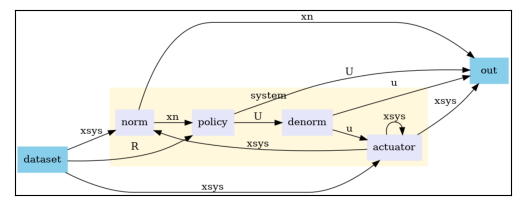

In [12]:
sys.change_backend('torch')
# We will have to denormalize the policy actions according to the system stats
# Conversely we will have to normalize the system states according to the system stats to hand to the policy

def norm(x):
    return sys.normalize(x, key='X')

def denorm(u):
    return sys.denormalize(u, key='U')

normnode = Node(norm, ['xsys'], ['xn'], name='norm')
denormnode = Node(denorm, ['U'], ['u'], name='denorm')
sysnode = Node(sys, ['xsys', 'u'], ['xsys'], name='actuator')
test_system = System([normnode, policy_node, denormnode, sysnode])
test_system.show()


## Evaluate on 1000 steps with a new reference trajectory distribution

{'R': torch.Size([1, 1000, 3]), 'xsys': torch.Size([1, 1, 3]), 'Time': (1, 1000, 1)}


/mnt/c/Users/tuor369/gitland/torchdiffeq/torchdiffeq/_impl/misc.py:15: UserWarning: Dopri5Solver: Unexpected arguments {'grid_points': tensor([0.0000, 0.1000]), 'eps': 1e-06}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
/mnt/c/Users/tuor369/gitland/neuromancer_wwu/neuromancer/src/neuromancer/psl/base.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.B.cast(method_output, dtype=self.B.core.float32)


{'R': torch.Size([1, 1000, 3]), 'xsys': torch.Size([1, 1001, 3]), 'Time': (1, 1000, 1), 'xn': torch.Size([1, 1000, 3]), 'U': torch.Size([1, 1000, 3]), 'u': torch.Size([1, 1000, 3])}


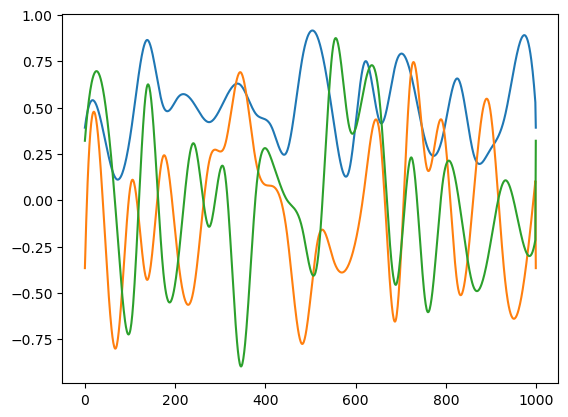

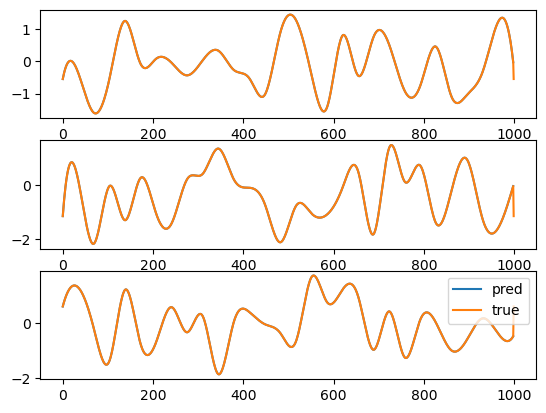

In [13]:
from neuromancer.psl.signals import sines, step, arma, spline
import numpy as np
references = spline(nsim=1000, d=sys.nx, min=sys.stats['X']['min'], max=sys.stats['X']['max'])
plt.plot(references)
test_data = {'R': torch.tensor(sys.normalize(references, key='X'), dtype=torch.float32).unsqueeze(0), 'xsys': sys.get_x0().reshape(1, 1, -1),
            'Time': (np.arange(1000)*sys.ts).reshape(1, 1000, 1)}
print({k: v.shape for k, v in test_data.items()})
test_system.nsteps=1000
with torch.no_grad():
    test_out = test_system(test_data)

print({k: v.shape for k, v in test_out.items()})
fix, ax = plt.subplots(nrows=3)
for v in range(3):
    ax[v].plot(test_out['xn'][0, 1:, v].detach().numpy(), label='pred')
    ax[v].plot(test_data['R'][0, :, v].detach().numpy(), label='true')
plt.legend()
plt.savefig('control.png')
